### MASt3R - Image Matching

In [1]:
from mast3r.model import AsymmetricMASt3R
from mast3r.fast_nn import fast_reciprocal_NNs

import mast3r.utils.path_to_dust3r
from dust3r.inference import inference
from dust3r.utils.image import load_images


# visualize a few matches
import numpy as np
import torch
import torchvision.transforms.functional
from matplotlib import pyplot as pl


>> Loading a list of 2 images
 - adding /home/jaykumaran/Office/mast3r/christ.png with resolution 832x819 --> 512x496
 - adding /home/jaykumaran/Office/mast3r/christ3.png with resolution 832x819 --> 512x496
 (Found 2 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


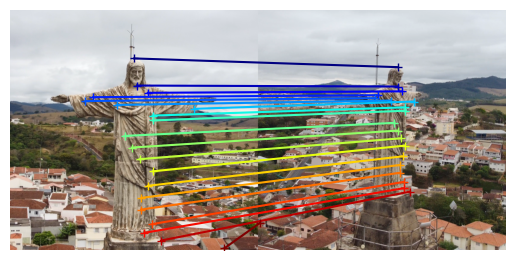

In [8]:
if __name__ == '__main__':
    device = 'cuda'
    schedule = 'cosine'
    lr = 0.01
    niter = 300

    model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
    # you can put the path to a local checkpoint in model_name if needed
    model = AsymmetricMASt3R.from_pretrained(model_name).to(device)
    images = load_images(['/home/jaykumaran/Office/mast3r/christ.png', '/home/jaykumaran/Office/mast3r/christ3.png'], size=512)
    output = inference([tuple(images)], model, device, batch_size=1, verbose=False)

    # at this stage, you have the raw dust3r predictions
    view1, pred1 = output['view1'], output['pred1']
    view2, pred2 = output['view2'], output['pred2']

    desc1, desc2 = pred1['desc'].squeeze(0).detach(), pred2['desc'].squeeze(0).detach()

    # find 2D-2D matches between the two images
    matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8,
                                                   device=device, dist='dot', block_size=2**13)

    # ignore small border around the edge
    H0, W0 = view1['true_shape'][0]
    valid_matches_im0 = (matches_im0[:, 0] >= 3) & (matches_im0[:, 0] < int(W0) - 3) & (
        matches_im0[:, 1] >= 3) & (matches_im0[:, 1] < int(H0) - 3)

    H1, W1 = view2['true_shape'][0]
    valid_matches_im1 = (matches_im1[:, 0] >= 3) & (matches_im1[:, 0] < int(W1) - 3) & (
        matches_im1[:, 1] >= 3) & (matches_im1[:, 1] < int(H1) - 3)

    valid_matches = valid_matches_im0 & valid_matches_im1
    matches_im0, matches_im1 = matches_im0[valid_matches], matches_im1[valid_matches]


    n_viz = 20
    num_matches = matches_im0.shape[0]
    match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
    viz_matches_im0, viz_matches_im1 = matches_im0[match_idx_to_viz], matches_im1[match_idx_to_viz]

    image_mean = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)
    image_std = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)

    viz_imgs = []
    for i, view in enumerate([view1, view2]):
        rgb_tensor = view['img'] * image_std + image_mean
        viz_imgs.append(rgb_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())

    H0, W0, H1, W1 = *viz_imgs[0].shape[:2], *viz_imgs[1].shape[:2]
    img0 = np.pad(viz_imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
    img1 = np.pad(viz_imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
    img = np.concatenate((img0, img1), axis=1)
    pl.figure()
    pl.axis('off')
    
    pl.imshow(img)
    
    cmap = pl.get_cmap('jet')
    for i in range(n_viz):
        (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
        pl.plot([x0, x1 + W0], [y0, y1], '-+', color=cmap(i / (n_viz - 1)), scalex=False, scaley=False)
    pl.savefig("output_mast3r_christ.jpg", dpi = 300, bbox_inches = 'tight', pad_inches = 0)
    pl.show(block=True)


### For Sequences 
One Anchor Image vs All other views

In [3]:
import cv2
import os

from mast3r.model import AsymmetricMASt3R
from mast3r.fast_nn import fast_reciprocal_NNs

import mast3r.utils.path_to_dust3r
from dust3r.inference import inference
from dust3r.utils.image import load_images

# visualize a few matches
import numpy as np
import torch
import torchvision.transforms.functional
from matplotlib import pyplot as pl


from moviepy.video.io.ImageSequenceClip import ImageSequenceClip


os.makedirs("matching_results", exist_ok=True)

if __name__ == '__main__':
    device = 'cuda'
    model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
    model = AsymmetricMASt3R.from_pretrained(model_name).to(device)
    
    # Define the image sequence directory
    anchor_image_path = '/home/jaykumaran/Downloads/clocktower/PXL_20250217_140953055.jpg'
    image_dir = '/home/jaykumaran/Downloads/clocktower'
    image_sequence = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
    
    print(len(image_sequence))
    
    anchor_image = load_images([anchor_image_path], size=512)[0]
    
    frames = []
    for img_path in image_sequence:
        current_image = load_images([img_path], size=512)[0]
        output = inference([(anchor_image, current_image)], model, device, batch_size=1, verbose=False)
        
        view1, pred1 = output['view1'], output['pred1']
        view2, pred2 = output['view2'], output['pred2']
        
        desc1, desc2 = pred1['desc'].squeeze(0).detach(), pred2['desc'].squeeze(0).detach()
        matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8,
                                                       device=device, dist='dot', block_size=2**13)
        
        H0, W0 = view1['true_shape'][0]
        H1, W1 = view2['true_shape'][0]
        
        valid_matches_im0 = (matches_im0[:, 0] >= 3) & (matches_im0[:, 0] < int(W0) - 3) & (
            matches_im0[:, 1] >= 3) & (matches_im0[:, 1] < int(H0) - 3)
        
        valid_matches_im1 = (matches_im1[:, 0] >= 3) & (matches_im1[:, 0] < int(W1) - 3) & (
            matches_im1[:, 1] >= 3) & (matches_im1[:, 1] < int(H1) - 3)
        
        valid_matches = valid_matches_im0 & valid_matches_im1
        matches_im0, matches_im1 = matches_im0[valid_matches], matches_im1[valid_matches]
        
        n_viz = 20
        num_matches = matches_im0.shape[0]
        match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
        viz_matches_im0, viz_matches_im1 = matches_im0[match_idx_to_viz], matches_im1[match_idx_to_viz]
        
        image_mean = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)
        image_std = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)
        
        viz_imgs = []
        for view in [view1, view2]:
            rgb_tensor = view['img'] * image_std + image_mean
            viz_imgs.append(rgb_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())
        
        img0 = np.pad(viz_imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
        img1 = np.pad(viz_imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
        img = np.concatenate((img0, img1), axis=1)
        
        pl.figure()
        pl.axis('off')
        pl.imshow(img)
        
        cmap = pl.get_cmap('jet')
        for i in range(n_viz):
            (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
            pl.plot([x0, x1 + W0], [y0, y1], '-+', color=cmap(i / (n_viz - 1)), scalex=False, scaley=False)
        
        frame_path = f"frame_{os.path.basename(img_path).replace('.png', '.jpg')}"
        
        pl.savefig(frame_path, dpi=300, bbox_inches='tight', pad_inches=0)
        print("Frame path", frame_path)
        frames.append(frame_path)
       
        
        pl.close()
        
    print("Length of frames",  len(frames))     
    
    # # Create video
    
    clip = ImageSequenceClip(frames, fps=5)
    clip.write_videofile("output_matching_clocktower_fps.mp4", codec="libx264")


22
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_140953055.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_140953055.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_140953055.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_140953265.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_140953265.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_140953693.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_140953693.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_140957024.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_140957024.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_141002127.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_141002127.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_141007557.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_141007557.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_141016511.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_141016511.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_141018785.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_141018785.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_141027419.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_141027419.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_141033378.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_141033378.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_141044120.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_141044120.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_141045965.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_141045965.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_141048784.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_141048784.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_141050334.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_141050334.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_141057829.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_141057829.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_141104485.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_141104485.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_141110724.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_141110724.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_141117771.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_141117771.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_141121266.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_141121266.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_141123366.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_141123366.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_141125644.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_141125644.jpg
>> Loading a list of 1 images
 - adding /home/jaykumaran/Downloads/clocktower/PXL_20250217_141127603.jpg with resolution 3072x4080 --> 384x512
 (Found 1 images)


/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Frame path frame_PXL_20250217_141127603.jpg
Length of frames 22
MoviePy - Building video output_matching_clocktower_fps.mp4.
MoviePy - Writing video output_matching_clocktower_fps.mp4



MoviePy - Done !
MoviePy - video ready output_matching_clocktower_fps.mp4


### DUSt3R - Visual Localization 

/home/jaykumaran/Office/mast3r/dust3r/dust3r/cloud_opt/base_opt.py:275: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


>> Loading a list of 2 images
 - adding /home/jaykumaran/Office/mast3r/christ.png with resolution 832x819 --> 512x496
 - adding /home/jaykumaran/Office/mast3r/christ3.png with resolution 832x819 --> 512x496
 (Found 2 images)
>> Inference with model on 2 image pairs


  0%|          | 0/2 [00:00<?, ?it/s]/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jaykumaran/Office/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


 init edge (1*,0*) score=2.2382397651672363
 init loss = 0.005242394283413887
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 300/300 [00:06<00:00, 43.09it/s, lr=1.27413e-06 loss=0.000591728]


found 11 matches


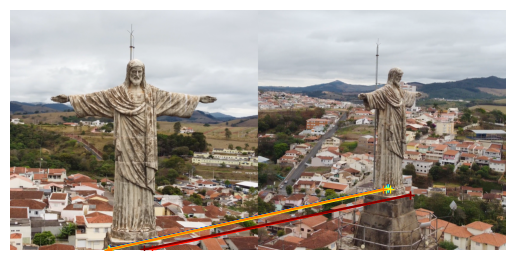

In [2]:
from dust3r.inference import inference
from dust3r.model import AsymmetricCroCo3DStereo
from dust3r.utils.image import load_images
from dust3r.image_pairs import make_pairs
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode

if __name__ == '__main__':
    device = 'cuda'
    batch_size = 1
    schedule = 'cosine'
    lr = 0.01
    niter = 300

    model_name = "naver/DUSt3R_ViTLarge_BaseDecoder_512_dpt"
    # you can put the path to a local checkpoint in model_name if needed
    model = AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device)
    # load_images can take a list of images or a directory
    images = load_images(['/home/jaykumaran/Office/mast3r/christ.png', '/home/jaykumaran/Office/mast3r/christ3.png'], size=512)
    pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
    output = inference(pairs, model, device, batch_size=batch_size)

    # at this stage, you have the raw dust3r predictions
    view1, pred1 = output['view1'], output['pred1']
    view2, pred2 = output['view2'], output['pred2']
    # here, view1, pred1, view2, pred2 are dicts of lists of len(2)
    #  -> because we symmetrize we have (im1, im2) and (im2, im1) pairs
    # in each view you have:
    # an integer image identifier: view1['idx'] and view2['idx']
    # the img: view1['img'] and view2['img']
    # the image shape: view1['true_shape'] and view2['true_shape']
    # an instance string output by the dataloader: view1['instance'] and view2['instance']
    # pred1 and pred2 contains the confidence values: pred1['conf'] and pred2['conf']
    # pred1 contains 3D points for view1['img'] in view1['img'] space: pred1['pts3d']
    # pred2 contains 3D points for view2['img'] in view1['img'] space: pred2['pts3d_in_other_view']

    # next we'll use the global_aligner to align the predictions
    # depending on your task, you may be fine with the raw output and not need it
    # with only two input images, you could use GlobalAlignerMode.PairViewer: it would just convert the output
    # if using GlobalAlignerMode.PairViewer, no need to run compute_global_alignment
    scene = global_aligner(output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer)
    loss = scene.compute_global_alignment(init="mst", niter=niter, schedule=schedule, lr=lr)

    # retrieve useful values from scene:
    imgs = scene.imgs
    focals = scene.get_focals()
    poses = scene.get_im_poses()
    pts3d = scene.get_pts3d()
    confidence_masks = scene.get_masks()

    # visualize reconstruction
    # scene.show()

    # find 2D-2D matches between the two images
    from dust3r.utils.geometry import find_reciprocal_matches, xy_grid
    pts2d_list, pts3d_list = [], []
    for i in range(2):
        conf_i = confidence_masks[i].cpu().numpy()
        pts2d_list.append(xy_grid(*imgs[i].shape[:2][::-1])[conf_i])  # imgs[i].shape[:2] = (H, W)
        pts3d_list.append(pts3d[i].detach().cpu().numpy()[conf_i])
    reciprocal_in_P2, nn2_in_P1, num_matches = find_reciprocal_matches(*pts3d_list)
    print(f'found {num_matches} matches')
    matches_im1 = pts2d_list[1][reciprocal_in_P2]
    matches_im0 = pts2d_list[0][nn2_in_P1][reciprocal_in_P2]

    # visualize a few matches
    import numpy as np
    from matplotlib import pyplot as pl
    n_viz = 10
    match_idx_to_viz = np.round(np.linspace(0, num_matches-1, n_viz)).astype(int)
    viz_matches_im0, viz_matches_im1 = matches_im0[match_idx_to_viz], matches_im1[match_idx_to_viz]

    H0, W0, H1, W1 = *imgs[0].shape[:2], *imgs[1].shape[:2]
    img0 = np.pad(imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
    img1 = np.pad(imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
    img = np.concatenate((img0, img1), axis=1)
    pl.figure()
    pl.imshow(img)
    cmap = pl.get_cmap('jet')
    pl.axis('off')
    for i in range(n_viz):
        (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
        pl.plot([x0, x1 + W0], [y0, y1], '-+', color=cmap(i / (n_viz - 1)), scalex=False, scaley=False)
    pl.savefig('output_dust3r_christ.jpg', dpi = 300, pad_inches = 0, bbox_inches = 'tight')
    pl.show(block=True)
